In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import AdamW
import numpy as np
import copy
from collections import deque
import gym
from gym.spaces import Discrete, Box
from itertools import count
import random
import matplotlib.pyplot as plt
from gym.wrappers import NormalizeObservation, NormalizeReward
import torch.optim as optim

In [2]:
env_name = 'LunarLanderContinuous-v2'

In [3]:
# Actor Network
class ActorNet(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(ActorNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.Tanh()
        )
        self.mu_head = nn.Linear(int(hidden_units/2),  output_size)
        self.logstd_head = nn.Linear(int(hidden_units/2),  output_size)

    def forward(self, x):
        x = self.model(x)
        loc = torch.tanh(self.mu_head(x)) * 2
        scale = torch.exp(self.logstd_head(x))
        return loc, scale

    def __call__(self, x):
        out = self.forward(x)
        return out

In [4]:
class CriticNet(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(CriticNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.Tanh()
        )
        self.value_head = nn.Linear(int(hidden_units/2), 1)

    def forward(self, x):
        x = self.model(x)
        value = self.value_head(x)
        return value

    def __call__(self, x):
        out = self.forward(x)
        return out

In [5]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [6]:
nenvs=8
env = gym.vector.make(env_name, num_envs=nenvs) #, new_step_api=True
#env = NormalizeObservation(env)
#env = NormalizeReward(env)
obs_dim = env.single_observation_space.shape[0]
n_acts = env.single_action_space.shape[0]

In [7]:
hidden_sizes = 128
actor_net = ActorNet(obs_dim, hidden_sizes, n_acts)
actor_net = actor_net.apply(initialize_weights)

critic_net = CriticNet(obs_dim, hidden_sizes, n_acts)
critic_net = critic_net.apply(initialize_weights)

In [8]:
# optimizer
actor_optimizer = AdamW(actor_net.parameters(), lr=0.001)
critic_optimizer = AdamW(critic_net.parameters(), lr=0.001)

In [9]:
T = lambda x: torch.as_tensor(x, dtype=torch.float32)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64)

In [10]:
class RunningMem():

    def __init__(self):
        self.reset()

    def store(self, obs, action, logprob, reward, done, obs_, values, values_):
        self.obs.append(obs)
        self.actions.append(action.unsqueeze(-1))
        self.logprobs.append(logprob)
        self.rewards.append(reward.unsqueeze(-1))
        self.dones.append(done.unsqueeze(-1))
        self.obs_.append(obs_)
        self.values.append(values)
        self.values_.append(values_)


    def batches(self, batchsize):
        size = nenvs*memsteps
        idx = list(range(size))
        random.shuffle(idx)

        b_obs = torch.stack(self.obs)
        b_actions = torch.stack(self.actions)
        b_logprobs = torch.stack(self.logprobs)
        b_rewards = torch.stack(self.rewards)
        b_dones = torch.stack(self.dones)
        b_obs_ = torch.stack(self.obs_)
        b_values = torch.stack(self.values)
        b_values_ = torch.stack(self.values_)

        gaes = []
        gae = T(np.zeros(nenvs)).view(nenvs,-1)
        for i in range(len(b_obs)-1,-1,-1):
            delta = b_rewards[i] + gamma * b_values_[i] * (1-b_dones[i]) - b_values[i]
            gae = delta + gamma * lmbda * (1-b_dones[i]) * gae
            gaes.insert(0, gae)
        
        b_obs = b_obs.view(size, -1)
        b_actions = b_actions.view(size, -1)
        b_logprobs = b_logprobs.view(size, -1)
        b_rewards = b_rewards.view(size, -1)
        b_dones = b_dones.view(size, -1)
        b_obs_ = b_obs_.view(size, -1)
        b_values = b_values.view(size, -1)
        b_values_ = b_values_.view(size, -1)
        b_gae = torch.stack(gaes).view(size, -1)

        for batchn in range(0, len(idx), batchsize):
            batchidx = idx[batchn:batchn+batchsize]
            batchidx = Ti(batchidx)
            mb_obs = torch.index_select(b_obs, 0, batchidx)
            mb_actions = torch.index_select(b_actions, 0, batchidx)
            mb_logprobs = torch.index_select(b_logprobs, 0, batchidx)
            mb_rewards = torch.index_select(b_rewards, 0, batchidx)
            mb_dones = torch.index_select(b_dones, 0, batchidx)
            mb_obs_ = torch.index_select(b_obs_, 0, batchidx)
            mb_values = torch.index_select(b_values, 0, batchidx)
            mb_values_ = torch.index_select(b_values_, 0, batchidx)
            mb_gae = torch.index_select(b_gae, 0, batchidx)
            yield mb_obs, mb_actions, mb_logprobs, mb_rewards, mb_dones, mb_obs_, mb_values, mb_values_, mb_gae


    def reset(self):
        self.obs = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.dones = []    
        self.obs_ = []
        self.values = []
        self.values_ = []
        self.gae = []

In [11]:
@torch.no_grad()
def sim_action(policy, obs):
    loc, std = policy(T(obs))
    dist = Normal(loc=loc, scale=std+1e-6)
    action = dist.sample()
    action_log_prob = torch.sum(dist.log_prob(action), dim=-1, keepdim=True)
    return action, action_log_prob

In [12]:
def train(mem, gamma, batchsize, epoch_repeat, epsilon, lmbda):
    for epochrep in range(epoch_repeat):
        for batch in mem.batches(batchsize=batchsize):
            obs, actions, logprobs, rewards, dones, obs_, values, values_, gae = batch
            gae = (gae - torch.mean(gae)) / (torch.std(gae) + 1e-6)
            target = gae + values
            state_values = critic_net(obs)
            critic_loss = F.smooth_l1_loss(state_values, target).mean()
            
            new_loc, new_scale = actor_net(obs)
            dist = Normal(loc=new_loc, scale=new_scale+1e-6)
            new_logprobs = torch.sum(dist.log_prob(actions), dim=-1, keepdim=True)
            rho = torch.exp(new_logprobs - logprobs)
            surrgt1 = rho * gae
            surrgt2 = rho.clamp(1-epsilon, 1+epsilon) * gae
            policy_loss = -torch.minimum(surrgt1, surrgt2).mean()

            loss = policy_loss + 0.5*critic_loss
            actor_optimizer.zero_grad()
            critic_optimizer.zero_grad()
            loss.backward()
            actor_optimizer.step()
            critic_optimizer.step()

In [13]:
results = deque(maxlen=50)
memsteps = 128
mem = RunningMem()
gamma=0.99
lmbda=0.95
epsilon = 0.18
batchsize=10
epoch_repeat=15
final_result=[]
temp = deque(maxlen=8)

totreward = np.zeros(nenvs)
stepcount = 0
epoc = 0
obs, info = env.reset()

while True: 
    stepcount+=1
    action, action_log_prob = sim_action(actor_net, obs)
    next_obs, reward, terminated, truncated, _ = env.step(action.numpy())
    with torch.no_grad():
            values = critic_net(T(obs))
            values_ = critic_net(T(next_obs))    
    mem.store(T(obs), action, action_log_prob, T(reward), Ti(terminated), T(next_obs), values, values_)
    obs = next_obs
    totreward += reward
    doneidx = np.where(terminated==True)
    for k in doneidx[0]:
        res = totreward[k]
        results.append(res)
        temp.append(res)
        totreward[k] = 0
       
    if stepcount>1 and stepcount % memsteps == 0:
        epoc+=1
        train(mem, gamma=gamma, batchsize=batchsize, epoch_repeat=epoch_repeat, epsilon=epsilon, lmbda=lmbda)  
        mem.reset()
        final_result.append(np.mean(temp)) 
        if epoc %50 == 0:
            print(f'Episode: {epoc} Avg Result: {np.mean(results)}')
            
    if len(results)>0 and np.mean(results)  >= 195:
        print(f'Solved!  Episode: {epoc} Avg Result: {np.mean(results)}')
        break

Episode: 50 Avg Result: -97.08423157725495
Episode: 100 Avg Result: 26.332995040289394
Episode: 150 Avg Result: -422.9123097230629
Episode: 200 Avg Result: -729.387578065604


ValueError: Expected parameter loc (Tensor of shape (10, 2)) of distribution Normal(loc: torch.Size([10, 2]), scale: torch.Size([10, 2])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], grad_fn=<MulBackward0>)

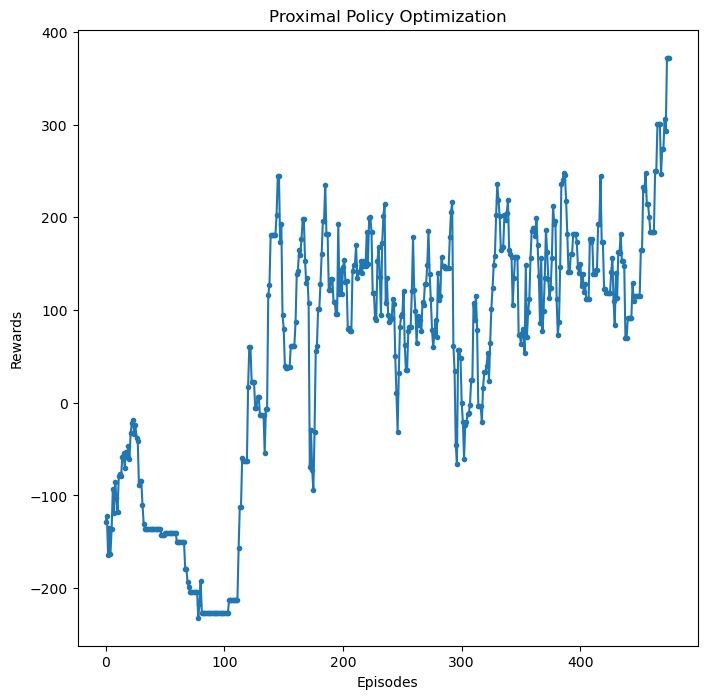

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(final_result)),final_result, marker='.')
plt.title('Proximal Policy Optimization')
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.show()